In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
# I think the below should be commented out
# for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2022-12-20 00:22:04.719754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 00:22:04.759710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 00:22:04.760145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2.8.0


# Load dictionaries of usable (non-blank, non-border) images

In [2]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [3]:
# Of the form {batch: {cell: {frame: -1/idx, ...}, ...}, ...} where good_imgs[batch][cell][frame] = -1 if the image
# is blank/on the border and idx if it is usable, where idx is the position in the list of usable images
train_good_imgs = load_img_dict('/data/dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('/data/dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('/data/dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('/data/dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('/data/dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('/data/dataset_pruning/val_border_dict.json')

In [4]:
def get_lst_idx_to_pos(good_imgs_dict):
    lst_idx_to_pos = {}
    for b in good_imgs_dict.keys():
        for c in good_imgs_dict[b].keys():
            for f in good_imgs_dict[b][c].keys():
                idx = good_imgs_dict[b][c][f]
                if idx != -1:
                    lst_idx_to_pos = (b, f, c)
    return lst_idx_to_pos

# Dictionary of frames to split (time until splitting) for each image, in the format of usable image dictionary
def get_life_cycle_dict(tracks):
    batches, frames, cells = tracks.centroids.shape[:3]
    
    life_cycle_dict = {}
    for batch in range(batches):
        life_cycle_dict[batch] = {}
        for cell in range(cells):
            life_cycle_dict[batch][cell] = {}
            for frame in range(frames):
                life_cycle_dict[batch][cell][frame] = -1
    
    for batch in range(batches):
        for cell in tracks.lineages[batch].keys():
            if len(tracks.lineages[batch][cell]['daughters']) != 0:
                cell_frames = tracks.lineages[batch][cell]['frames']
                last_frame = cell_frames[-1]
                for cell_frame in cell_frames:
                    life_cycle_dict[batch][cell - 1][cell_frame] = last_frame - cell_frame + 1
    
    return life_cycle_dict

# Should the cells in the dictionary be 0-indexed? What is the case in the good_imgs_dict?
# Yes. It is 0-indexed wrt the cells

# Write appearances array to TF Records

In [5]:
import csv
import os

from tensorflow.data import Dataset
from tensorflow.io import serialize_tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import is_sparse

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

def create_tracking_example(image):
    # define the dictionary -- the structure -- of our single example
    data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image))
    }
    # create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))
    
    return out

In [6]:
# No (extra) normalization
def write_tracking_dataset_to_tfr(track, filename, good_imgs):
    print('Done calculating normalizations.')
    filename = "/data/tf_records/" + filename + ".tfrecords"
    writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
    count = 0

    app = track.appearances
    # Only write usable images to the record
    for b in range(app.shape[0]):
        print(b)
        for f in range(app.shape[1]):
            for c in range(app.shape[2]):
                # Check if the given image is usable
                if good_imgs[b][c][f] != -1:
                    current_image = app[b, f, c]

                    out = create_tracking_example(current_image)

                    if out is not None:
                        writer.write(out.SerializeToString())
                        count += 1

    writer.close()
    print(f'Wrote {count} elements to TFRecord')
    return count

In [7]:
train_trks = load_trks(os.path.join('/data', 'train.trks'))
# val_trks = load_trks(os.path.join('/data', 'val.trks'))

In [8]:
from skimage.exposure import rescale_intensity

def norm(X, size):
    X_norm = histogram_normalization(X, kernel_size=size)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(-0.5, 0.5))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [14]:
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done creating Track objects.')

    write_tracking_dataset_to_tfr(val_tracks, filename='val_big_norm_contracted', good_imgs=val_good_imgs)

Done calculating normalizations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Wrote 89436 elements to TFRecord


In [9]:
with tf.device('/cpu:0'):
    train_tracks = Track(tracked_data=train_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done with creating Track objects.')

    write_tracking_dataset_to_tfr(train_tracks, filename='train_big_norm_contracted', good_imgs=train_good_imgs)

2022-12-20 00:24:51.025439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 00:24:51.027731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 00:24:51.028004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 00:24:51.028172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Done with creating Track objects.
Done calculating normalizations.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
Wrote 383800 elements to TFRecord


In [9]:
train_life_cycle_dict = get_life_cycle_dict(train_tracks)
val_life_cycle_dict = get_life_cycle_dict(val_tracks)

NameError: name 'train_tracks' is not defined

# Load images from TF Records

In [10]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_image = content['raw_image']
    

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, feature)

In [11]:
def get_dataset(filename, batch_size=1, buffer_size=256,
                    seed=None):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(
      parse_tfr_element
    )
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
val_dataset = get_dataset("/data/tf_records/val_big_norm_contracted.tfrecords", batch_size=100)
train_dataset = get_dataset("/data/tf_records/train_big_norm_contracted.tfrecords", batch_size=100)

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [14]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [15]:
# VAE with 4 encoding and decoding layers, 64 filters per convolution, KL-divergence weight 1
# dim_z, kl_weight, learning_rate, n_filters, n_layers, side
vae = VAE(16, 1, 1e-3, 64, 4, 64)
AE = vae.build_vae_keras_model()

2022-12-20 07:31:03.999210: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [18]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 8
# model_path = '/data/models/big_img_4_layers_16_embed_10_beta'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)#,
#     tf.keras.callbacks.ModelCheckpoint(
#         model_path, monitor='val_loss',
#         save_best_only=True, verbose=1,
#         save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/8


2022-12-20 07:33:36.273134: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-12-20 07:33:39.257454: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3838/3838 [==============================] - 86s 21ms/step - loss: nan - val_loss: nan - lr: 0.0010
Epoch 2/8
 377/3838 [=>............................] - ETA: 1:04 - loss: nan

KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt

x = np.array([train_dataset[0][0][0]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

print(x[0, 0, 0])
print(x[0, 30, 30])

TypeError: 'PrefetchDataset' object is not subscriptable

In [12]:
val_dataset = get_dataset("/data/tf_records/val_big.tfrecords", batch_size=100)
train_dataset = get_dataset("/data/tf_records/train_big.tfrecords", batch_size=100)

In [13]:
# VAE with 4 encoding and decoding layers, 64 filters per convolution, KL-divergence weight 1
# dim_z, kl_weight, learning_rate, n_filters, n_layers, side
vae2 = VAE(16, 1, 1e-3, 64, 4, 64)
AE2 = vae.build_vae_keras_model()

In [15]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 4
# model_path = '/data/models/big_img_4_layers_16_embed_10_beta'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7)#,
#     tf.keras.callbacks.ModelCheckpoint(
#         model_path, monitor='val_loss',
#         save_best_only=True, verbose=1,
#         save_weights_only=True)
]

loss_history = AE2.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/4
3838/3838 [==============================] - 154s 40ms/step - loss: -5496.5293 - val_loss: 5227.3755 - lr: 0.0010
Epoch 2/4
3838/3838 [==============================] - 154s 40ms/step - loss: -6287.4819 - val_loss: 570.2474 - lr: 0.0010
Epoch 3/4
3838/3838 [==============================] - 153s 40ms/step - loss: -6690.2344 - val_loss: -1890.8573 - lr: 0.0010
Epoch 4/4
3838/3838 [==============================] - 153s 40ms/step - loss: -5318.7632 - val_loss: -2278.5364 - lr: 0.0010


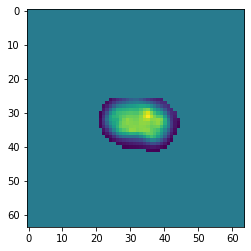

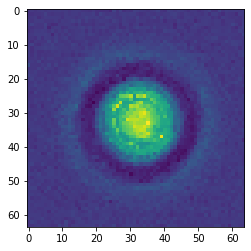

In [17]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][13][6]])
xhat = AE2(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])